# Evolutionary algorithms - fall 2019 term project assignment
Davide Passaniti - 201983510 - dpassaniti@pusan.ac.kr


---



I. For each of the 4 given benchmark functions:

* implement SGA with
 * simulated binary crossover nc=2, pc=0.9
 * polynomial mutation nm=10, pm=1/D 
 * Selection mehtods:
   * (1)stochastic universal sampling
   * (2)binary tournament selection
* (3) implement GA with restricted tournament selection
  * (with the same reproductive operators as the previous SGA)
* compare 1 with 2, winner with 3
* plot best so far curve for 1, 2 and 3

II. Report results

### Initialization

In [0]:
import numpy as np
import math
import random
from matplotlib import pyplot as plt

N = 100 # population size (odd value might cause errors)
testNo = 10#n of tests per algorithm

#generate random number in a given range
def randDomain(dmin, dmax):
  return (dmax-dmin)*np.random.random() + dmin

#initialize an array of chromosomes
def initPopulation(size, dimensions, domainMin, domainMax):
  pop = np.empty((size,dimensions),dtype=float)
  for chromosome in np.arange(size):
    for gene in np.arange(dimensions):
      pop[chromosome][gene] = randDomain(domainMin, domainMax)
  return pop

#return array with fitness of each member
def evaluateF(population, function):
  size = population.shape[0]
  fit = np.empty(size, dtype=float)
  for c in np.arange(size):
    fit[c] = 1/function(population[c])
  return fit

### Rosenbrock function

In [0]:
#IN: chromosome (c) 
#OUT: rosenbrock of c (sigma)
def rosenbrock(c):
  sigma = 0
  for i in np.arange(c.size-1):
    x = c[i]
    x2 = c[i+1]
    sigma += 100*(x2-x**2)**2 + (1-x)**2
  return sigma

#dimensions, domain min, domain max, crossover rate, mutation rate
rosSet={"dims": 30,
        "doMin": -30.0,
        "doMax": 30.0,
        "cRate": 0.9,
        "mRate": 1.0/30.0}

### Rastrigin function

In [0]:
#IN: chromosome (c) 
#OUT: rastrigin of c (sigma)
def rastrigin(c):
  sigma = 10*c.size
  for i in np.arange(c.size):
    x = c[i]
    sigma += x**2 - 10*math.cos(2*math.pi*x)
  return sigma

#dimensions, domain min, domain max, crossover rate, mutation rate
rasSet={"dims": 30,
        "doMin": -5.12,
        "doMax": 5.12,
        "cRate": 0.9,
        "mRate": 1.0/30.0}

### Griewank function

In [0]:
#IN: chromosome (c) 
#OUT: griewank of c (sigma)
def griewank(c):
  sigma = 1
  productoria = 1
  for i in np.arange(c.size):
    x = c[i]
    sigma += (x**2)/4000
    productoria *= math.cos(x/math.sqrt(i+1))
  return (sigma - productoria)

#dimensions, domain min, domain max, crossover rate, mutation rate
griSet={"dims": 30,
        "doMin": -600.0,
        "doMax": 600.0,
        "cRate": 0.9,
        "mRate": 1.0/30.0}

### Kowalik function

In [0]:
#IN: chromosome (c) 
#OUT: kowalik of c (out)
def kowalik(c):
  x1 = c[0]
  x2 = c[1]
  return (4*x1**2 - 2.1*x1**2 + (x1**6)/3 + x1*x2 - 4*x2**2 + 4*x2**4)

#dimensions, domain min, domain max, crossover rate, mutation rate
kowSet={"dims": 2,
        "doMin": -5.0,
        "doMax": 5.0,
        "cRate": 0.9,
        "mRate": 1.0/4.0}

### Simulated binary crossover (SBX)

In [0]:
#IN: control parameter (n)
#OUT: spread factor for SBX
def getSpreadFactor(n):
  #inverse transform sampling from given density distribution:
  #p(B) = {0.5*(n+1)*(B**n), B<= 1
  #        0.5(n+1)*1/B**(n+2), B > 1}
  #maths adapted from: https://stackoverflow.com/a/58829624
  u = np.random.random()
  if(u <= 0.5):
    return (2.0*u)**(1.0/(n+1.0))
  else:
    return (1.0/2.0*(1-u))**(1.0/(n+1.0))

#IN: two parent chromosomes (p1, p2), control parameter (n=2)
#OUT: two offspring (c1, c2)
def SBX(p1, p2, n=2.0):  
  c1 = np.empty(p1.size)
  c2 = np.empty(p1.size)
  for i in np.arange(p1.size):
    beta = getSpreadFactor(n)
    c1[i] = 0.5*(p1[i]+p2[i]) + 0.5*beta*(p1[i]-p2[i])
    c2[i] = 0.5*(p1[i]+p2[i]) + 0.5*beta*(p2[i]-p1[i])
  return c1, c2

# # TEST
# pop = initPopulation(2, 5, rosSet["doMin"], rosSet["doMax"])
# p1 = pop[0]
# p2 = pop[1]
# print(p1)
# print(p2)
# c1,c2 = SBX(p1,p2)
# print(c1)
# print(c2)

### Polynomial mutation

In [0]:
#IN: chromosome (c), search domain [min,max] (dom), control parameter (n=10)
#OUT: mutated chromosome (mc)
def polyMut(c, dom, n=10.0):
  mc = np.empty(c.size)
  #adapted from mutPolynomialBounded @ https://github.com/DEAP/deap/blob/master/deap/tools/mutation.py
  for i in np.arange(c.size):
    mc[i] = c[i]

    #search space (+/- max perturbation) 
    dMin = dom[0]
    dMax = dom[1]

    delta1 = (mc[i] - dMin) / (dMax - dMin)
    delta2 = (dMax - mc[i]) / (dMax - dMin)
    rand = np.random.random()
    mutPow = 1.0/(n+1.0)

    if(rand < 0.5):
      xy = 1.0 - delta1
      val = 2.0 * rand + (1.0 - 2.0 * rand) * xy**(n+1)
      deltaQ = val**mutPow - 1.0

    else:
      xy = 1.0 - delta2
      val = 2.0 * (1.0-rand) + 2.0 * (rand-0.5) * xy**(n+1)
      deltaQ =  1.0 - val**mutPow

    mc[i] += deltaQ * (dMax - dMin)    
    mc[i] = min(max(mc[i], dMin), dMax)
      
  return mc

# # TEST
# size = 5
# c = np.empty(size)
# for i in np.arange(size):
#   c[i] = randDomain(-30,30)
# print(c)
# print(polyMut(c, [-30,30]))

### Stochastic universal sampling

In [0]:
#IN: population of chromosomes from which to select (pop)
#    array of fitnesses (fit) and how many members to select (k)
#OUT: list of k selected members
def SUS(pop, fit, k):
  dist = np.sum(fit)/float(k)
  start = dist * np.random.random()
  points = [start + i*dist for i in np.arange(k)]

  selected = []
  for p in points:
    i = 0
    sum = fit[i]
    while(sum < p):
      i+=1
      if(i >= fit.size):
        i = 0
      sum+=fit[i]
    selected.append(np.copy(pop[i]))
  return selected

# # TEST
# currentPop = initPopulation(N, 30, -30, 30)
# fit = evaluateF(currentPop, rosenbrock)
# maxf = np.amax(fit)
# minf = np.amin(fit)
# maxcount = 0
# mincount = 0
# tests = 100
# selections = N
# for i in range(tests):
#   parents = SUS(currentPop, fit, selections)
#   parents = np.array(parents)
#   for c in np.arange(selections):
#     fit[c] = 1/rosenbrock(parents[c])
#   for f in fit:
#     if(f == maxf):
#       maxcount+=1
#     if(f == minf):
#       mincount+=1
# print("maxf picks ",maxcount)
# print("expected ratio:",maxf/np.sum(fit))
# print("actual ratio", maxcount/(tests*selections))
# print("minf picks ",mincount)
# print("expected ratio:",minf/np.sum(fit))
# print("actual ratio",mincount/(tests*selections))

### Binary tournament selection

In [0]:
#IN: population of chromosomes from which to select (pop)
#    array of fitnesses (fit)
#OUT: the selected chromosome
def binTourSel(pop, fit):
  rand1 = math.floor(randDomain(0, pop.shape[0]))
  rand2 = math.floor(randDomain(0, pop.shape[0]))
  if(fit[rand1] > fit[rand2]):
    return pop[rand1]
  elif(fit[rand1] != fit[rand2]):
    return pop[rand2]
  else:#tie
    return random.choice([pop[rand1], pop[rand2]])

# # TEST
# currentPop = initPopulation(N, 30, -30, 30)
# fit = evaluateF(currentPop, rosenbrock)
# parent1 = binTourSel(currentPop, fit)
# parent2 = binTourSel(currentPop, fit)
# print(parent1,"\n\n",parent2)

### Standard Genetic Algorithm


* Random gen N sized population of chromosomes
* (2) Calculate fitness of each chromosome
* repeat until N offsprings are created:
  * Select two parents
  * crossover w/ pc
  * mutation w/ pm
* replace current population with new population
* go to step (2) unless termination condition

In [0]:
#values for each test function
settings = [rosSet, rasSet, griSet, kowSet]
funcs = [rosenbrock, rastrigin, griewank, kowalik]
flabel = ["Rosenbrock", "Rastrigin", "Griewank", "Kowalik"]
#termination conditions
#0 convergence quickly -> ~100
#1 continuous slow improvement -> 1000~10000
#2 very slow continuous improvement after 500 -> ~1000
#3 convergence very quickly -> 50~100
endCond = [100, 10000, 1000, 100]

#### With Stochastic Universal Sampling

In [40]:
fig, axs = plt.subplots(4, 2, figsize=(15, 20), facecolor='w')
title = f"SGA with stochastic universal sampling\nbest-so-far curves of {testNo} runs"
fig.suptitle(title, fontsize=16)
fig.subplots_adjust(hspace = .5, wspace=.25)
axs = axs.ravel()
for a in axs:
  a.set_xlabel("Generation")
  a.set_ylabel("Objective Value")
  a.grid()

#record testNo runs
rosBests = []
rasBests = []
griBests = []
kowBests = []
bestsSUS = [rosBests, rasBests, griBests, kowBests]
history = [[],[],[],[]]
for test in range(testNo):
  #SGA loop, once per function
  for fun in np.arange(4):
    #initialise population
    pop = initPopulation(N, settings[fun]["dims"], settings[fun]["doMin"], settings[fun]["doMax"])  
    bestSoFar = []
    #termination condition at n loops
    for i in np.arange(endCond[fun]):
      #evaluate fitness
      fit = evaluateF(pop, funcs[fun])
      
      #record best so far
      currentBest = 1/np.amax(fit)
      if(len(bestSoFar) > 0):
        if(currentBest < bestSoFar[-1]):
          bestSoFar.append(currentBest)
        else:
          bestSoFar.append(bestSoFar[-1])
      else:
        bestSoFar.append(currentBest)

      newPop = np.empty((N,settings[fun]["dims"]),dtype=float)
      #select N parents
      parentPool = SUS(pop, fit, N)
      #take sampled parents in pairs to make offsprings
      for c in np.arange(start=0, stop=N, step=2):
        #crossover
        if(np.random.random() < settings[fun]["cRate"]):
          off1, off2 = SBX(parentPool[c],parentPool[c+1])
        else:
          off1 = np.copy(parentPool[c])
          off2 = np.copy(parentPool[c+1])

        #mutation
        dom = [settings[fun]["doMin"], settings[fun]["doMax"]]
        if(np.random.random() < settings[fun]["mRate"]):
          off1 = polyMut(off1, dom)
        if(np.random.random() < settings[fun]["mRate"]):
          off2 = polyMut(off2, dom)
        
        newPop[c]=off1
        newPop[c+1]=off2
        
      #discard old population
      pop = newPop
    
    #record best of this run
    bestsSUS[fun].append(bestSoFar[-1])
    #record history
    if(len(history[fun]) > 0):
      for vi in range(len(bestSoFar)):
        history[fun][vi] += bestSoFar[vi]
    else:
      history[fun] = bestSoFar
    #plot all runs
    info = flabel[fun] + f"\nBest solution OV:{min(bestsSUS[fun]):.5f}\n"
    axs[fun*2].set_title(info)
    axs[fun*2].plot(bestSoFar)

#plot typical run
memberAvg = lambda x: x/testNo
for fun in range(4):
  avg = list(map(memberAvg, history[fun]))
  axs[(fun*2)+1].set_title("Typical run for "+flabel[fun]+"\n ")
  axs[(fun*2)+1].plot(avg)


#### With Binary Tournament Selection

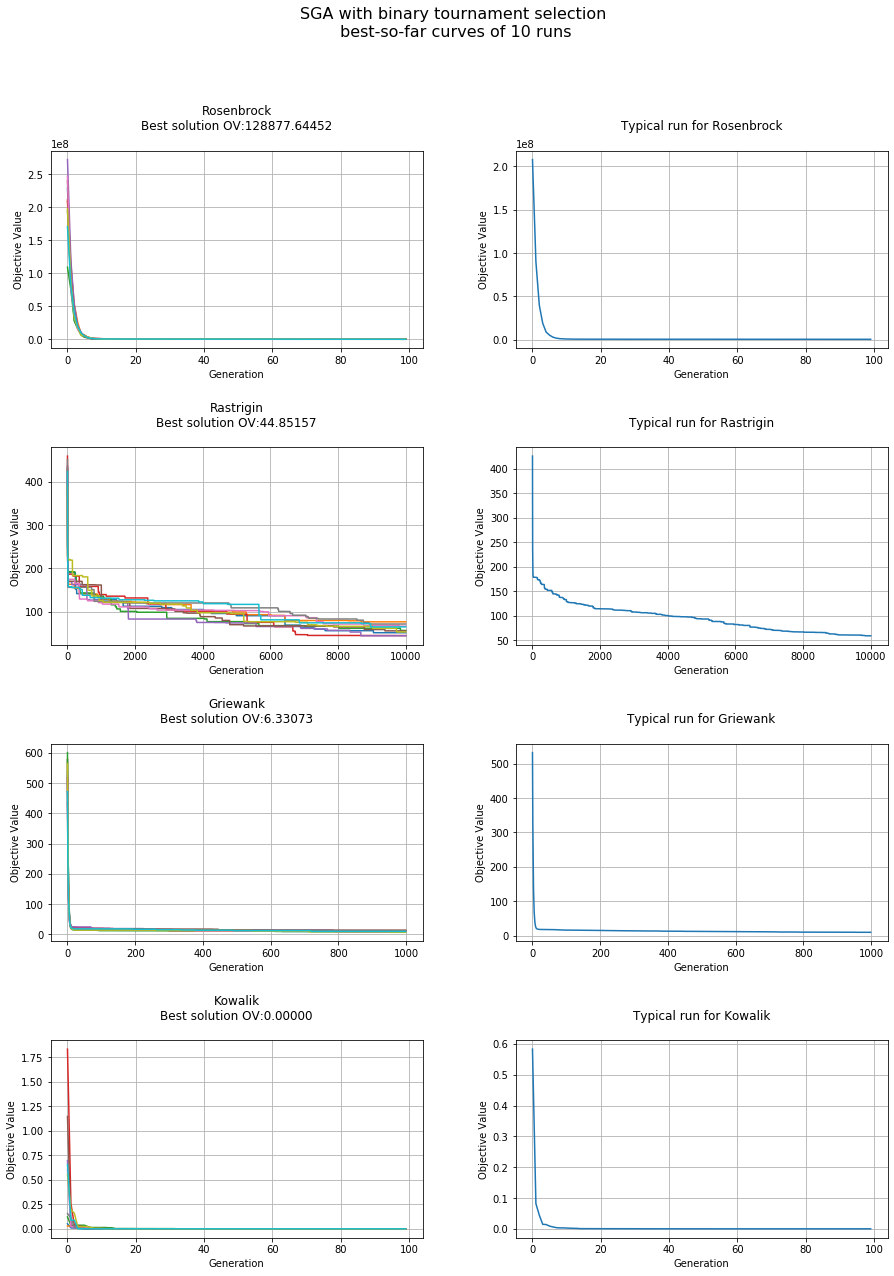

In [41]:
fig, axs = plt.subplots(4, 2, figsize=(15, 20), facecolor='w')
title = f"SGA with binary tournament selection \nbest-so-far curves of {testNo} runs"
fig.suptitle(title, fontsize=16)
fig.subplots_adjust(hspace = .5, wspace=.25)
axs = axs.ravel()
for a in axs:
  a.set_xlabel("Generation")
  a.set_ylabel("Objective Value")
  a.grid()

#record testNo runs
rosBests = []
rasBests = []
griBests = []
kowBests = []
bestsBTS = [rosBests, rasBests, griBests, kowBests]
history = [[],[],[],[]]
for test in range(testNo):
  #SGA loop, once per function
  for fun in np.arange(4):
    #initialise population
    pop = initPopulation(N, settings[fun]["dims"], settings[fun]["doMin"], settings[fun]["doMax"]) 
    bestSoFar = []
    #termination condition at n loops
    for i in np.arange(endCond[fun]):
      #evaluate fitness
      fit = evaluateF(pop, funcs[fun])
      
      #record best so far
      currentBest = 1/np.amax(fit)
      if(len(bestSoFar) > 0):
        if(currentBest < bestSoFar[-1]):
          bestSoFar.append(currentBest)
        else:
          bestSoFar.append(bestSoFar[-1])
      else:
        bestSoFar.append(currentBest)

      newPop = np.empty((N,settings[fun]["dims"]),dtype=float)
      #2 offsprings per loop
      for c in np.arange(start=0, stop=N, step=2):
        #select 2 parents
        parentPool = [binTourSel(pop, fit), binTourSel(pop, fit)]

        #crossover
        if(np.random.random() < settings[fun]["cRate"]):
          off1, off2 = SBX(parentPool[0],parentPool[1])
        else:
          off1 = np.copy(parentPool[0])
          off2 = np.copy(parentPool[1])

        #mutation
        dom = [settings[fun]["doMin"], settings[fun]["doMax"]]
        if(np.random.random() < settings[fun]["mRate"]):
          off1 = polyMut(off1, dom)
        if(np.random.random() < settings[fun]["mRate"]):
          off2 = polyMut(off2, dom)
        
        newPop[c]=off1
        newPop[c+1]=off2
        
      #discard old population
      pop = newPop

    #record best of this run
    bestsBTS[fun].append(bestSoFar[-1])
    #record history
    if(len(history[fun]) > 0):
      for vi in range(len(bestSoFar)):
        history[fun][vi] += bestSoFar[vi]
    else:
      history[fun] = bestSoFar
    #plot all runs
    info = flabel[fun] + f"\nBest solution OV:{min(bestsBTS[fun]):.5f}\n"
    axs[fun*2].set_title(info)
    axs[fun*2].plot(bestSoFar)

#plot typical run
memberAvg = lambda x: x/testNo
for fun in range(4):
  avg = list(map(memberAvg, history[fun]))
  axs[(fun*2)+1].set_title("Typical run for "+flabel[fun]+"\n ")
  axs[(fun*2)+1].plot(avg)


### GA with Restricted Tournament Selection


* Random gen N sized population of chromosomes
* (2) Calculate fitness of each chromosome
* repeat until N offsprings are created:
  * Randomly select m parents
  * generate m offspring with:
    * crossover w/ pc
    * mutation w/ pm
  * for each offspring o:
    * evaluate fitness of o
    * randomly select w members from the current population
    * among those, find the member closest to o, c
    * if o has higher fitness than c, remove c from the population and add o
* go to step (2) unless termination condition

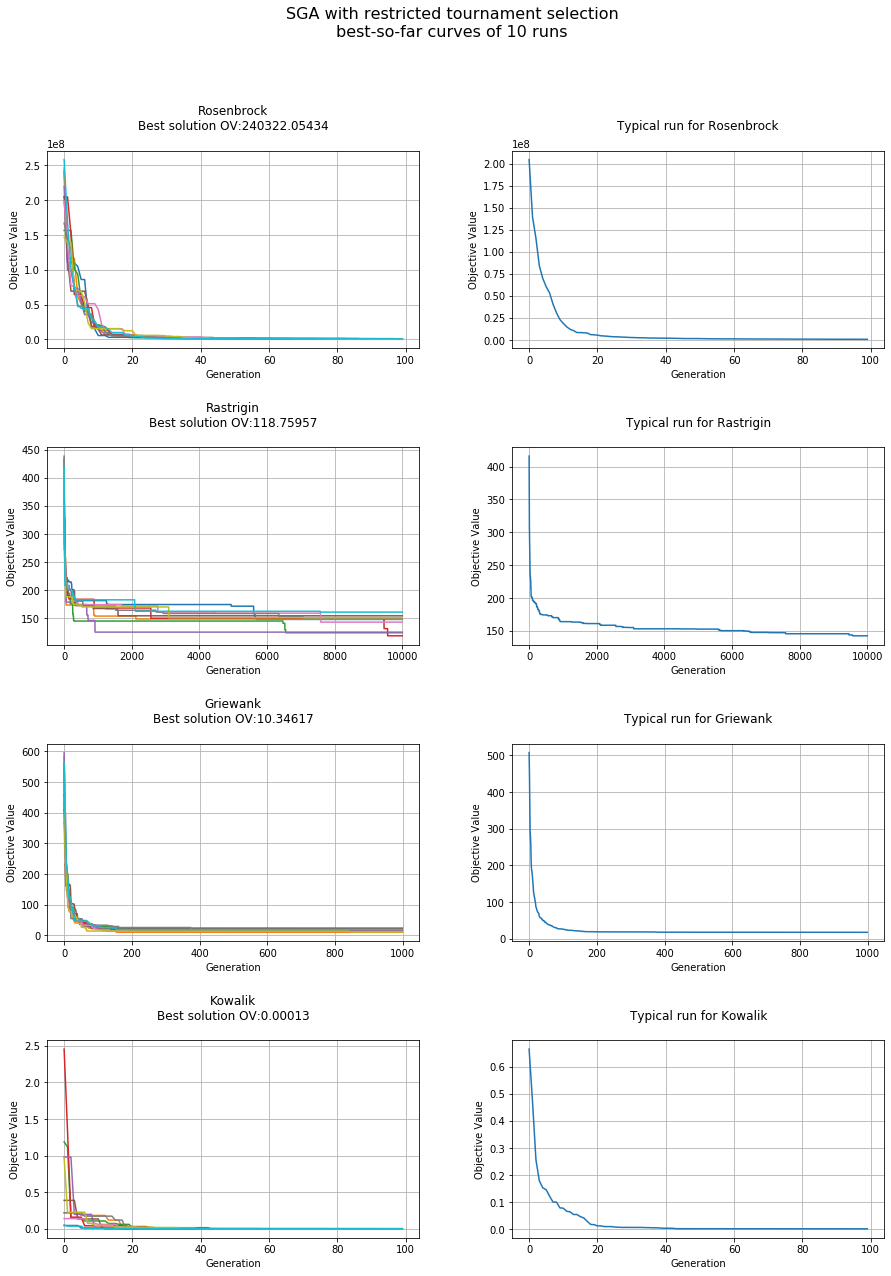

In [42]:
#IN: reference fitness (ref), list of other's fitnesses (fit)
#OUT: index of most similar element (closest)
def findMostSimilar(ref, fit):
  closest = 2
  indx = 0
  for i in np.arange(fit.size):
    dist = abs(ref-fit[i]) 
    if (dist < closest):
      closest = dist
      indx = i
  return indx

fig, axs = plt.subplots(4,2, figsize=(15, 20), facecolor='w')
title = f"GA with restricted tournament selection\nbest-so-far curves of {testNo} runs"
fig.suptitle(title, fontsize=16)
fig.subplots_adjust(hspace = .5, wspace=.25)
axs = axs.ravel()
for a in axs:
  a.set_xlabel("Generation")
  a.set_ylabel("Objective Value")
  a.grid()

#record testNo runs
rosBests = []
rasBests = []
griBests = []
kowBests = []
bestsRTS = [rosBests, rasBests, griBests, kowBests]
history = [[],[],[],[]]
for test in range(testNo):
  #SGA loop, once per function
  for fun in np.arange(4):
    #initialise population
    pop = initPopulation(N, settings[fun]["dims"], settings[fun]["doMin"], settings[fun]["doMax"])
    bestSoFar = []
    #termination condition at n loops
    for i in np.arange(endCond[fun]):
      #evaluate fitness
      fit = evaluateF(pop, funcs[fun])
      
      #record best so far
      currentBest = 1/np.amax(fit)
      if(len(bestSoFar) > 0):
        if(currentBest < bestSoFar[-1]):
          bestSoFar.append(currentBest)
        else:
          bestSoFar.append(bestSoFar[-1])
      else:
        bestSoFar.append(currentBest)

      #new population = old population at the beginning
      newPop = np.copy(pop)
      #generate offsprings with restricted tournament selection
      poolSize = 10 #(even number)
      for c in np.arange(poolSize):
        #create mating pool
        parentPool = []
        for i in np.arange(poolSize):
          rand = math.floor(randDomain(0, pop.shape[0]))
          parentPool.append(pop[rand])
        parentPool = np.array(parentPool)

        #create poolsize offspring
        offsprings = []
        for i in np.arange(start = 0, stop=poolSize, step=2):
          #crossover
          if(np.random.random() < settings[fun]["cRate"]):
            off1, off2 = SBX(parentPool[i],parentPool[i+1])
          else:
            off1 = np.copy(parentPool[i])
            off2 = np.copy(parentPool[i+1])
          #mutation
          dom = [settings[fun]["doMin"], settings[fun]["doMax"]]
          if(np.random.random() < settings[fun]["mRate"]):
            off1 = polyMut(off1, dom)
          if(np.random.random() < settings[fun]["mRate"]):
            off2 = polyMut(off2, dom)
          offsprings.append(off1)
          offsprings.append(off2)
        offsprings = np.array(offsprings)

        #compare each offspring with closest in comparison pool
        compPoolSize = poolSize
        for off in offsprings:
          offFit = 1/funcs[fun](off)
          compPoolFits = [fit[math.floor(randDomain(0, pop.shape[0]))]
                        for i in np.arange(compPoolSize)]
          ms = findMostSimilar(offFit, np.array(compPoolFits))
          if(offFit > fit[ms]):
            #replace with new offspring
            newPop[c]=off
        
      #discard old population
      pop = newPop

    #record best of this run
    bestsRTS[fun].append(bestSoFar[-1])
    #record history
    if(len(history[fun]) > 0):
      for vi in range(len(bestSoFar)):
        history[fun][vi] += bestSoFar[vi]
    else:
      history[fun] = bestSoFar
    #plot all runs
    info = flabel[fun] + f"\nBest solution OV:{min(bestsRTS[fun]):.5f}\n"
    axs[fun*2].set_title(info)
    axs[fun*2].plot(bestSoFar)

#plot typical run
memberAvg = lambda x: x/testNo
for fun in range(4):
  avg = list(map(memberAvg, history[fun]))
  axs[(fun*2)+1].set_title("Typical run for "+flabel[fun]+"\n ")
  axs[(fun*2)+1].plot(avg)


### Performance evaluation

In [0]:
#indices
ROS = 0#rosenbrock
RAS = 1#rastrigin
GRI = 2#griewank
KOW = 3#kowalik

#best solutions
bestsSUS = np.array(bestsSUS)
bestsBTS = np.array(bestsBTS)
bestsRTS = np.array(bestsRTS)

#means and variances
meansSUS = np.empty(4)
varsSUS = np.empty(4)

meansBTS = np.empty(4)
varsBTS = np.empty(4)

meansRTS = np.empty(4)
varsRTS = np.empty(4)

for i in range(4):
  meansSUS[i] = np.mean(bestsSUS[i])
  varsSUS[i] = np.var(bestsSUS[i])

  meansBTS[i] = np.mean(bestsBTS[i])
  varsBTS[i] = np.var(bestsBTS[i])

  meansRTS[i] = np.mean(bestsRTS[i])
  varsRTS[i] = np.var(bestsRTS[i])

#### Box plots

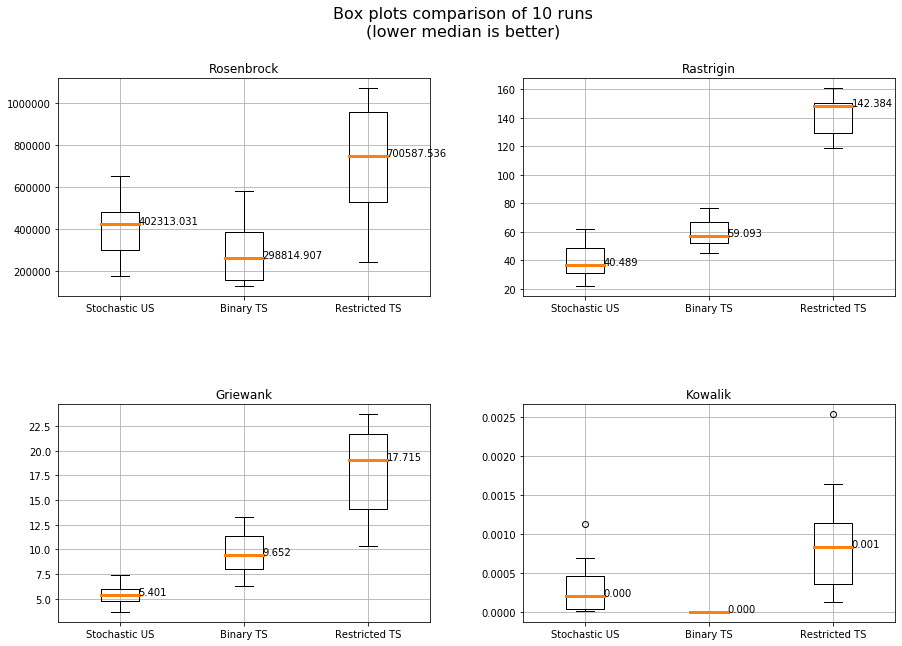

In [186]:
fig, ax = plt.subplots(2,2, figsize=(15,10),facecolor='w')
title = f"Box plots comparison of {testNo} runs\n(lower median is better)"
fig.suptitle(title, fontsize=16)
fig.subplots_adjust(hspace = .5, wspace=.25)
axs=ax.ravel()

#for each function
means = [meansSUS, meansBTS, meansRTS]
for i in range(4):
  axs[i].set_title(flabel[i])
  data = axs[i].boxplot([bestsSUS[i], bestsBTS[i], bestsRTS[i]], medianprops={"linewidth":"3"})
  #write median value on the graph
  for k in range(len(data['medians'])):
    x, y = data['medians'][k].get_xydata()[1]
    axs[i].annotate(f'{means[k][i]:.3f}',(x, y))

  axs[i].set_xticklabels(["Stochastic US", "Binary TS", "Restricted TS"])
  axs[i].grid()
plt.show()

#### Paired t-testing

In [212]:
#IN: list of samples from two algorithms to compare (samples1, samples2)
#OUT: t value (t)
def tTest(samples1, samples2):
  diff = lambda x,y: x-y
  d = np.array(list(map(diff, samples1, samples2)))
  dmean = np.mean(d)
  dvar = np.var(d)
  t = dmean/(np.sqrt(dvar/d.size))
  return t

### ros

print("Rosenbrock function:\n")

print("Stochastic universal sampling SUS VS binary tournament selection BT\n")
print(f"SUS: mean = {meansSUS[ROS]:.5f} , best solution = {np.min(bestsSUS[ROS]):.5f}")
print(f"BTS: mean = {meansBTS[ROS]:.5f} , best solution = {np.min(bestsBTS[ROS]):.5f}")
t = tTest(bestsSUS[ROS], bestsBTS[ROS])
print(f"t = {t:.5f}\n")

print("winner BTS VS restricted tournament selection RTS\n")
print(f"BTS: mean = {meansBTS[ROS]:.5f} , best solution = {np.min(bestsBTS[ROS]):.5f}")
print(f"RTS: mean = {meansRTS[ROS]:.5f} , best solution = {np.min(bestsRTS[ROS]):.5f}")
t = tTest(bestsBTS[ROS], bestsRTS[ROS])
print(f"t = {t:.5f}\n")

### ras

print("Rastrigin function:\n")

print("Stochastic universal sampling SUS VS binary tournament selection BTS\n")
print(f"SUS: mean = {meansSUS[RAS]:.5f} , best solution = {np.min(bestsSUS[RAS]):.5f}")
print(f"BTS: mean = {meansBTS[RAS]:.5f} , best solution = {np.min(bestsBTS[RAS]):.5f}")
t = tTest(bestsSUS[RAS], bestsBTS[RAS])
print(f"t = {t:.5f}\n")

print("winner SUS VS restricted tournament selection RTS")
print(f"SUS: mean = {meansSUS[RAS]:.5f} , best solution = {np.min(bestsSUS[RAS]):.5f}")
print(f"RTS: mean = {meansRTS[RAS]:.5f} , best solution = {np.min(bestsRTS[RAS]):.5f}")
t = tTest(bestsSUS[RAS], bestsRTS[RAS])
print(f"t = {t:.5f}\n")

### gri

print("Griewank function:\n")

print("Stochastic universal sampling SUS VS binary tournament selection BTS\n")
print(f"SUS: mean = {meansSUS[GRI]:.5f} , best solution = {np.min(bestsSUS[GRI]):.5f}")
print(f"BTS: mean = {meansBTS[GRI]:.5f} , best solution = {np.min(bestsBTS[GRI]):.5f}")
t = tTest(bestsSUS[GRI], bestsBTS[GRI])
print(f"t = {t:.5f}\n")

print("winner SUS VS restricted tournament selection RTS\n")
print(f"SUS: mean = {meansSUS[GRI]:.5f} , best solution = {np.min(bestsSUS[GRI]):.5f}")
print(f"RTS: mean = {meansRTS[GRI]:.5f} , best solution = {np.min(bestsRTS[GRI]):.5f}")
t = tTest(bestsSUS[GRI], bestsRTS[GRI])
print(f"t = {t:.5f}\n")

### kow

print("Kowalik function:\n")

print("Stochastic universal sampling SUS VS binary tournament selection BTS\n")
print(f"SUS: mean = {meansSUS[KOW]:.5f} , best solution = {np.min(bestsSUS[KOW]):.5f}")
print(f"BTS: mean = {meansBTS[KOW]:.5f} , best solution = {np.min(bestsBTS[KOW]):.5f}")
t = tTest(bestsSUS[KOW], bestsBTS[KOW])
print(f"t = {t:.5f}\n")

print("winner BTS VS restricted tournament selection RTS\n")
print(f"BTS: mean = {meansBTS[KOW]:.5f} , best solution = {np.min(bestsBTS[KOW]):.5f}")
print(f"RTS: mean = {meansRTS[KOW]:.5f} , best solution = {np.min(bestsRTS[KOW]):.5f}")
t = tTest(bestsBTS[KOW], bestsRTS[KOW])
print(f"t = {t:.5f}\n")

Rosenbrock function:

Stochastic universal sampling SUS VS binary tournament selection BT

SUS: mean = 402313.03100 , best solution = 175669.87795
BTS: mean = 298814.90676 , best solution = 128877.64452
t = 1.45303

winner BTS VS restricted tournament selection RTS

BTS: mean = 298814.90676 , best solution = 128877.64452
RTS: mean = 700587.53594 , best solution = 240322.05434
t = -3.53880

Rastrigin function:

Stochastic universal sampling SUS VS binary tournament selection BTS

SUS: mean = 40.48904 , best solution = 22.07777
BTS: mean = 59.09327 , best solution = 44.85157
t = -3.50438

winner SUS VS restricted tournament selection RTS
SUS: mean = 40.48904 , best solution = 22.07777
RTS: mean = 142.38406 , best solution = 118.75957
t = -23.25745

Griewank function:

Stochastic universal sampling SUS VS binary tournament selection BTS

SUS: mean = 5.40121 , best solution = 3.69236
BTS: mean = 9.65190 , best solution = 6.33073
t = -5.76987

winner SUS VS restricted tournament selection R